In [16]:
import os, pickle
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [17]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [18]:
def load_industry_data(industry):
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [data_dir.format(industry) + "/" + f for f in all_csvs] 
    
    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(
                            csv,
                            sheet_name='Partner'
                            )
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, "More than one world data found"

        df = df[[
                'Year',
                'Export (US$ Thousand)',
                'Import (US$ Thousand)',
                'Revealed comparative advantage', 
                'World Growth (%)', 'Country Growth (%)', 
                'AHS Simple Average (%)', 'AHS Dutiable Tariff Lines Share (%)',
                    ]]
        df.reset_index(
                    drop=True, 
                    inplace=True
                    )
        all_data.append(df)

    all_data = pd.concat(all_data)
    all_data.reset_index(
                        drop=True, 
                        inplace=True
                        )
    
    all_data.fillna(
                    all_data.mean(), 
                    inplace=True
                    )
    all_data = all_data.astype(float)
    all_data.sort_values(
                        by='Year', 
                        inplace=True
                        )
    del all_data['Year']

    scaler = StandardScaler()
    scaler.fit(all_data)
    
    with open(model_dir.format(f"{industry} Scalar.pickle"), 'wb') as f:
        pickle.dump(scaler, f)
        
    all_data = pd.DataFrame(
                            scaler.transform(all_data), 
                            columns=all_data.columns
                            )
    return all_data

def make_ts_dataset(
                    industry,
                    selective_window = 7
                    ):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(1, len(df) - selective_window):

        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]
        y2 = df.iloc[i+selective_window, 1]

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    X = np.array(X)
    Y1 = np.array(Y1)
    Y2 = np.array(Y2)
    
    return X, Y1, Y2

### Load Sample Data

In [19]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (8, 7, 7)
Export Data Shape :  (8,)
Import Data Shape :  (8,)


## Build, Train, Evaluate model

In [20]:
def build_ts_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(128, return_sequences=True),
                                        tf.keras.layers.GRU(128),
                                        tf.keras.layers.Dense(1)
                                        ])

    model.compile(
                loss='mse',
                optimizer='adam', 
                metrics=['mae']
                )
    return model

def train_ts_model(
                    industry,
                    epochs=100,
                    batch_size=4
                    ):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
                                X, 
                                Y1, 
                                epochs=epochs,
                                batch_size=batch_size
                                )
    
    history_exp = model_exp.fit(
                                X, 
                                Y2, 
                                epochs=epochs,
                                batch_size=batch_size
                                )
    
    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    return history_imp, history_exp

def plot_loss(
            industry,
            history_imp, 
            history_exp
            ):
    
    plt.figure(figsize=(10, 5)) 

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw materials ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.5470 - mae: 0.4813
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2416 - mae: 0.4020 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2098 - mae: 0.4221  
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1376 - mae: 0.3390
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1001 - mae: 0.2675
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0835 - mae: 0.2488
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0970 - mae: 0.2783  
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0826 - mae: 0.2636  
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0513 - mae: 0.2017
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.0570 - mae: 0.2021  
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0652 - mae: 0.2129 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - lo

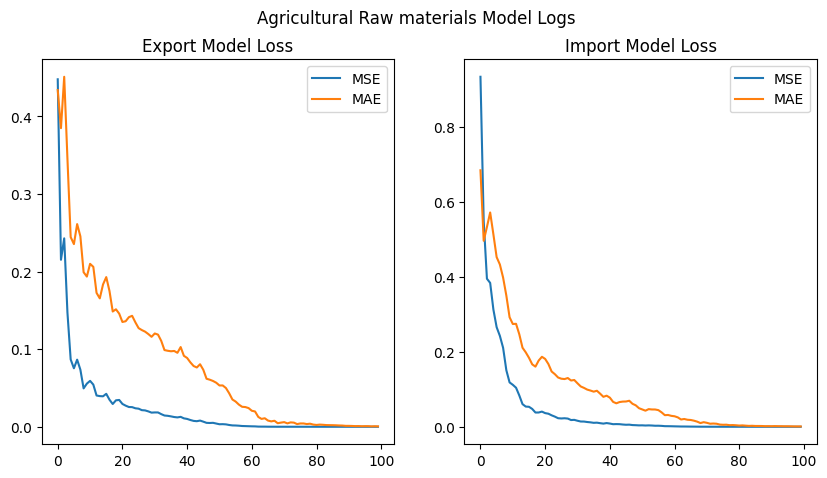

In [21]:
run_ts_model('Agricultural Raw materials')

................ Training on : Consumer goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 0s/step - loss: 0.5807 - mae: 0.6854
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3599 - mae: 0.4871 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1780 - mae: 0.3683
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1979 - mae: 0.3482 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2298 - mae: 0.3687 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1346 - mae: 0.2755
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1080 - mae: 0.2888 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0965 - mae: 0.2802
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1325 - mae: 0.3050
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1084 - mae: 0.2716
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0776 - mae: 0.2479 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0576 - m

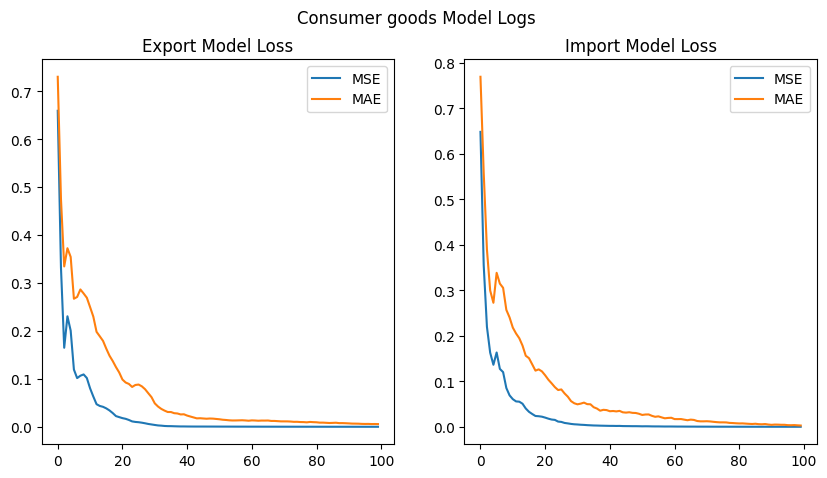

In [22]:
run_ts_model('Consumer goods')

................ Training on : Transportation ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.8824 - mae: 1.0202
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9571 - mae: 0.6839 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9446 - mae: 0.7850
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6350 - mae: 0.5786
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9236 - mae: 0.7695 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9686 - mae: 0.8748 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5731 - mae: 0.6409
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7119 - mae: 0.7674
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5123 - mae: 0.6249
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7060 - mae: 0.7167 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6500 - mae: 0.6812
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5196 -

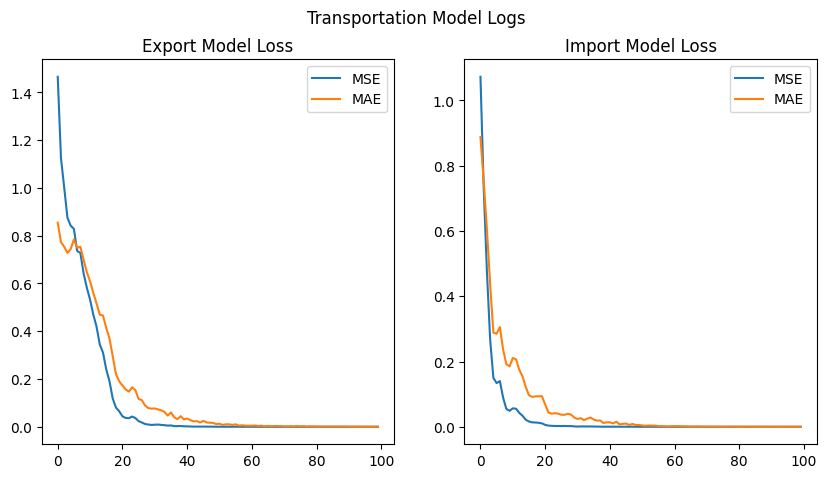

In [23]:
run_ts_model('Transportation')

................ Training on : Food industry ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 0s/step - loss: 0.8050 - mae: 0.6660
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6710 - mae: 0.5644
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.3002 - mae: 0.4110  
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1054 - mae: 0.2873
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2063 - mae: 0.3644  
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1751 - mae: 0.3534
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1390 - mae: 0.2967
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0776 - mae: 0.2385
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0606 - mae: 0.1875
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0977 - mae: 0.2437
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1074 - mae: 0.2573
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0769 - m

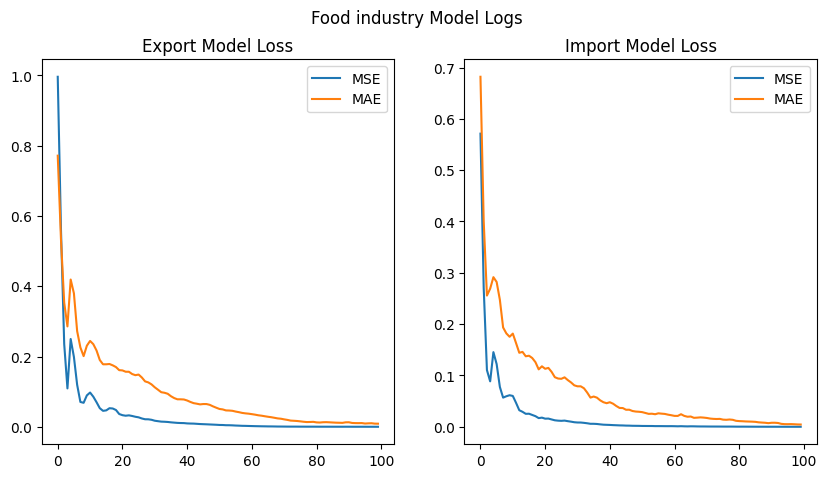

In [24]:
run_ts_model('Food industry')

................ Training on : Capital goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 0s/step - loss: 0.5930 - mae: 0.6505
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.2705 - mae: 0.3943  
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3588 - mae: 0.4642
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3383 - mae: 0.4686
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2559 - mae: 0.4031
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3149 - mae: 0.4294
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2890 - mae: 0.4661
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2283 - mae: 0.3956
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2136 - mae: 0.3702 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1778 - mae: 0.3269
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1986 - mae: 0.3690 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1255 - ma

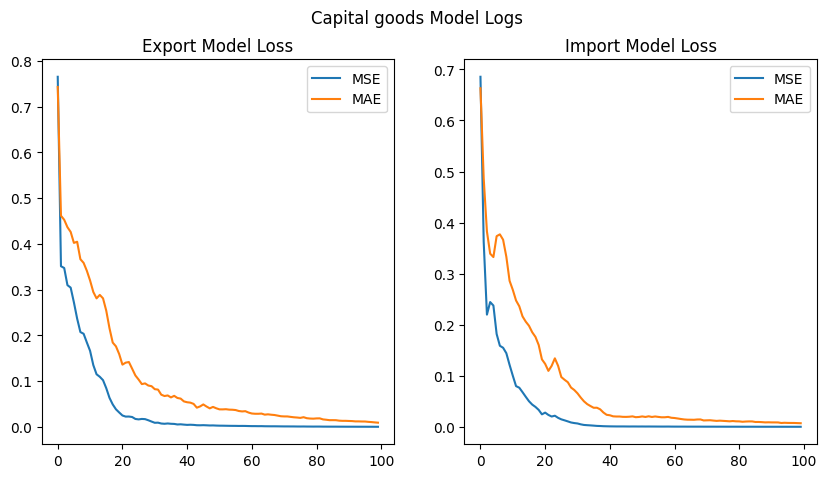

In [25]:
run_ts_model('Capital goods')

## Inference

In [26]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [27]:
def predict_ts_on_industry(
                            industry, 
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)
    
    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp) 
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)
    
    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [30]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Export Change : 24.06%
Predicted Import Change : 17.70%
